In [50]:
# Adam Jussila
# 11/1/2017
# 1D_raypath.py - this code is intended to run a set of "photons" moving radially 
# outward from a point source representing a pulsar. These photons will travel 
# randomly with gassian deflections through several screens and be forced to hit
# a specified point at the end, representing us as the observer recieving them.
# It also will calculate the delay of a given photon at each step relative to a 
# straight line path.

# v2b - 3/23/18 - Adam & Dan - takes Adam's 3/23 code and adds Dan's
#                 more general screen strength specification.

# v3 - 12/23/18 - Jakob & Adam & Dan - different parts of the code remodeled for improved
#                 functionality, valitidity tests, and added ability to
#                 produce multiple scintillation arcs

import scipy.ndimage
import numpy as np
import matplotlib.pyplot as plt
import random as rand

In [63]:
######################################################################
#################### RAYTRACE FUNCTION HERE ##########################
######################################################################

def raytrace_2d(nrays, sigma0, vel, nscr):

# seed random number generator here (a second one below!!!@#@)
#    np.random.seed(380340)
#    rand.seed(32422005)
    
#    The screen strength weighting scheme is as follows (screen j):

#        sigma0 = passed in: sets the scale of all the deflections
#        Sr[j] = strength of the random component of the ray
#        Sd[j] = strength of the directed component of the ray
#          A[j] = axial ratio   sigmax/sigmay ; y gets divided by this value
#          psi[j] = position angle (rel. to x-axis) of the directed component

    # creating variables. Path is x or y location at each screen.
    # thetax and thetay are the angular positions at each screen.
    # omega and tau are the delay and fringe frequency corroloaries
    nscreen = nscr
    pathx = np.zeros((nrays, nscreen+1)) # x position. nscreen indices. 
    pathy = np.zeros((nrays, nscreen+1)) # y position with nscreen indices.
    thetax = np.zeros((nrays, nscreen+1)) # one deflection angle at each screen plus the initial one.
    thetay = np.zeros((nrays, nscreen+1))
    tau = np.zeros(nrays) # array that holds delays
    omega = np.zeros(nrays) # array of omega values for each ray.

    Sd = np.zeros(nrays)  # strength (in units of sigma0) of directed component
    psi = np.zeros(nrays)  # position angle (reltative to x-axis) of directed component
    AR = np.ones(nrays)    # axial ratio of ellipse  sigmay = sigmax / AR
    Sr = np.ones(nrays)
    #Sr = Sr*2.

    #Sd[74] = 40
    Sd[50] = 90
    AR[50] = 30.
    psi[50] = np.pi / 4

    # amplitudes
    amp = np.zeros(nrays)
    dz = 3.1e19/nscreen # distance between screens (1kpc is 3.1e19 meters)

    # GENERATE EACH RAY HERE:
    for i in range(nrays):
        pathx[i,0] = 0
        pathy[i,0] = 0
        for j in range(nscreen+1):
    
            # calc whether it is affected by a big screen or not.
            # transmit means it is affected (1 is deflected, 0 is not)
            # ***this is where multiple arcs become relevant***
            #screen_prob = rand.random()
            #if ( screen_prob <= 0.10 ):
            #    transmit = 1
            #else:
            #    transmit = 0
            transmit = 1
            
            theta1 = 0
            theta2 = 0
            # this is the general ray creation mechanism.
            gx = rand.gauss(0,1) # x amplitude of directed component
            gy = rand.gauss(0,1) # y amplitude of directed component
            gr = rand.gauss(0,1) # amplitude of the random component
            psi_rand = 2.*np.pi*rand.random()  # uniform [0, 2 pi)            
            
            theta1 = sigma0*(Sd[j]*transmit*(gx*np.cos(psi[j]) - gy*np.sin(psi[j])/AR[j]) + Sr[j]*gr*np.cos(psi_rand))
            theta2 = sigma0*(Sd[j]*(gx*np.sin(psi[j]) + gy*np.cos(psi[j])/AR[j]) + Sr[j]*gr*np.sin(psi_rand))
            
            # Calculate the amplitude of this ray
               # may need tweaking - Dan (3/23/18)

            amp[i] += (gx**2 + gy**2)           
            # adjust theta based on what our deflection did to photons.
            thetax[i,j] = thetax[i,j-1] + theta1
            thetay[i,j] = thetay[i,j-1] + theta2

            # tracks the path the ray takes.
            pathx[i,j] = ((thetax[i,j])*dz) + pathx[i,j-1]
            pathy[i,j] = ((thetay[i,j])*dz) + pathy[i,j-1]

        # take the sigma values and subtract avg, find probability
        amp[i] = amp[i] - (amp.max())
        amp[i] = np.exp(-amp[i])

    # converge on the observer more neatly by subtracting a small amount from
    # each step.   
    for ray in range(nrays):
        dispx = (pathx[ray,nscreen])/(nscreen)
        dispy = (pathy[ray,nscreen])/(nscreen)
        for scr in range(1,nscreen+1):
            pathx[ray,scr] = pathx[ray,scr] - (dispx*(scr))
            pathy[ray,scr] = pathy[ray,scr] - (dispy*(scr))

    # calculate the omega values assuming the pulsar is moving in only x or 
    # y direction and not a combination of the two.
    
    # the total weighting sum, divides at end.
    sum_weights = 0
    sj = 0.0
    wj = 0.0
    for i in range(1,nscreen):
        # the screen fractional distance
        sj = float(i)/float(nscreen)
        sjminus = float(i-1)/float(nscreen)
        # the screen weighting
        wj = (sj/(1-sj) - sjminus/(1-sjminus))
        # adding each weighting to the total
        sum_weights += wj


    # getting omega values
    for ray in range(nrays):
        for i in range(1,nscreen):
            # the screen fractional distance
            sj = float(i)/float(nscreen)
            sjminus = float(i-1)/float(nscreen)

            # the screen weighting
            wj = (sj/(1-sj)- sjminus/(1-sjminus))

            # update theta values for the bent ray
            thetax[ray,i] = (pathx[ray,i]-pathx[ray,i-1])/dz
            thetay[ray,i] = (pathy[ray,i]-pathy[ray,i-1])/dz

            # add the screen plus the weighting
            omega[ray] += (thetax[ray,i]*wj)

            # gets the tau delays relative to to straight-line path. (small
            # angle approximation used here. )
            xdelay = ((thetax[ray,i]**2)*dz)/(2*(3e8)) #seconds
            ydelay = ((thetay[ray,i]**2)*dz)/(2*(3e8)) #seconds
            tau[ray] += np.sqrt(xdelay**2+ydelay**2)

    # print(thetax[ray,nscreen])

        # calculate the final omega by getting right units/undo weighting
        omega[ray] = 2*np.pi*omega[ray]*vel/(sum_weights*0.37) #divide by wavelength of .37m

    # random phase approximation for a given ray.
    # phi = 2.0 * np.pi * np.random.rand(nrays) # random phase

    # set the omega and tau values to zero and make ray 0 the source point.
    amp[0] = 1e-2
    omega[0] = 0
    tau[0] = 0

    # FIND ALL INTERFERENCE TERMS HERE
    sec = [(0,0) for i in range(nrays*nrays)]
    sec_amp = np.zeros(nrays*nrays)
    idx = 0
    for ray1 in range(nrays):
        for ray2 in range(nrays):
            if (ray1 != ray2):
                # difference term
                sec[idx] = ((omega[ray2]-omega[ray1]),(tau[ray2]-tau[ray1]))
            elif (ray1 == ray2):
                # self term
                sec[idx] = (0,0)

            #saving the amplitude of the combined rays for every interference.
            sec_amp[idx] = amp[ray1]*amp[ray2]
            idx += 1
    
    # if you wanted to, this is where you would create a dynamic.
    #########    dyn = makeDyn(nx,ny,nscreen,phi,omega,tau, nrays)

    return pathx, pathy, thetax, thetay, sec, tau, omega, sec_amp

In [64]:
######################################################################
##################### MAKE DYNAMIC HERE ##############################
######################################################################

# make the dynamic when given all of the component (delay, omega, phi)
def makeDyn(nx,ny, nscreen, phi, omega, tau, nrays):

    # make 1-D arrays that store the index values of each point.
    t = np.linspace(0,3600,nx)
    v = np.linspace(800000000,870000000,ny)

    # making empty arrays to store the 2-D indices
    tt = np.zeros((nx,ny))
    vv = np.zeros((nx,ny))

    for row in range(nx):
        for col in range(ny):
            tt[row][col] = t[col]
            vv[row][col] = v[row]

    efield = np.zeros((nx,ny))

    for i in range(nrays):
        c = (np.cos(np.pi*((omega[i]*tt) + (tau[i]*vv)) + phi[i]))
        efield = efield + c
    efield = efield**2
    
    efield = scipy.ndimage.filters.gaussian_filter(efield,1)

    return efield

In [65]:
#####################################################################
###################### MAKE SECONDARY HERE ##########################
#####################################################################

def makeSec(dyn, nrays):
    sec = np.fft.fftn(dyn)
    sec = np.absolute(np.fft.fftshift(sec))**2
    sec = 10*np.log10(sec/np.max(sec))
    return sec

<ipython-input-67-9422c404723f>:33: RuntimeWarning: divide by zero encountered in log
  full_sec = np.log(full_sec)


shape xi (50, 50)
shape yi (50, 50)
shape zi (2500,)


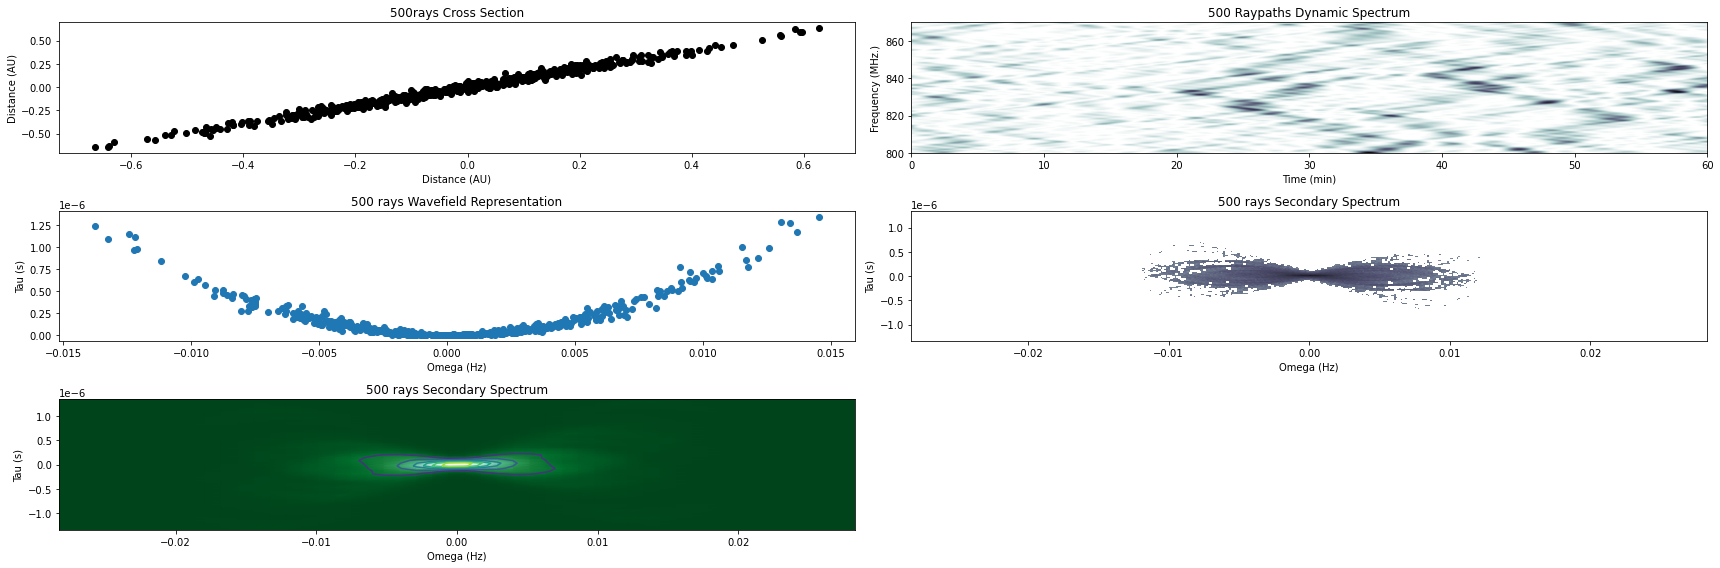

In [67]:
######################################################################
################# MAIN FUNCTION HERE #################################
######################################################################

def main():
    vel = 200000 #meters per second
    nscreen = 100
    trials = 500; #number of raypaths
    sigma0 = 0.01; #overall angular scale (milliarcseconds = mas)
    sigma0 = sigma0 / 2.06e+08      # convert to radians
    pathx, pathy, thetax, thetay, secondary, tau, omega, sec_amp  = \
            raytrace_2d(trials,sigma0, vel, nscreen)
    sec = secondary

    #separating out the tuples into an x and a y and add each one amp times.
    sec_amp = sec_amp.astype(float)
    x = np.zeros(trials*trials); y = np.zeros(trials*trials)
    idx = 0
    for point in range(len(sec)):
        x[idx] = sec[point][0]
        y[idx] = sec[point][1]
        idx += 1

    max = 0
    for ray in range(trials):
        if (np.abs(omega[ray]) > np.abs(omega[max])):
            max = ray

    #create a power spectrum with amplitudes and coordinates.
    full_sec, xlim, ylim = np.histogram2d(y,x,bins=512,weights=sec_amp)

# logarithm to see the power in fainter features
    full_sec = np.log(full_sec)

#    fig = plt.figure(figsize=(12,8))
#    ax1 = fig.add_subplot(221)
#    ax1.set_title(str(trials)+" Raypaths with Screen")
#    ax1.set_ylabel("Distance (AU)")
#    ax1.set_xlabel("Screen Number")
#
## raytracing plot
#    for i in range(trials):
#        plt.plot(pathx[i]/(10**11), c='black')
        
# pulsar image plot
    fig = plt.figure(figsize=(24,8))
    ax1 = fig.add_subplot(321)
    ax1.set_title(str(trials) + "rays Cross Section")
    ax1.set_ylabel("Distance (AU)")
    ax1.set_xlabel("Distance (AU)")

    for i in range(trials):
        plt.plot(pathx[i,50]/(10**11),pathy[i,50]/(10**11), c='black', marker='o')

# dynamic spectrum
    ax1 = fig.add_subplot(322)
    ax1.set_title(str(trials) +" Raypaths Dynamic Spectrum")
    ax1.set_ylabel("Frequency (MHz.)")
    ax1.set_xlabel("Time (min)")

    # making the dynamic spectrum stuff
    # random phase approximation for a given ray.
    phi = 2.0 * np.pi * np.random.rand(trials) # random phase
    nx = 1024
    ny = 1024
    dyn = makeDyn(nx,ny, nscreen, phi, omega, tau, trials)
    plt.imshow(dyn, extent=[0,60,800,870], aspect='auto', cmap='bone_r')
    
# wavefield picture
    ax1 = fig.add_subplot(323)
    ax1.set_title(str(trials) +" rays Wavefield Representation")
    ax1.set_xlabel("Omega (Hz)")
    ax1.set_ylabel("Tau (s)")
    plt.plot(omega,tau,linestyle='none',marker='o')

# secondary spectrum
    ax1 = fig.add_subplot(324)
    ax1.set_title( str(trials) +" rays Secondary Spectrum")
    ax1.set_xlabel("Omega (Hz)")
    ax1.set_ylabel("Tau (s)")
    plt.imshow(full_sec, extent=[np.min(x), np.max(x), np.min(y), np.max(y)], aspect='auto',cmap='bone_r')

# evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
 
    from scipy.stats import kde
    
    nbins=50
    k = kde.gaussian_kde([x,y])
    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    print ("shape xi", np.shape(xi))
    print ("shape yi", np.shape(yi))
    print ("shape zi", np.shape(zi))

# KDE contour
    ax1 = fig.add_subplot(325)
    ax1.set_title( str(trials) +" rays Secondary Spectrum")
    ax1.set_xlabel("Omega (Hz)")
    ax1.set_ylabel("Tau (s)")
    plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r)
    plt.contour(xi, yi, zi.reshape(xi.shape))

    # plot all of the images
    plt.tight_layout()
    plt.show()

main()